# Example notebook: Different samplers

In this notebook we demonstrate how to use different samplers for a basic portfolio optimization problem.

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dwave.samplers import RandomSampler, SimulatedAnnealingSampler
from dwave.system import DWaveSampler, LazyFixedEmbeddingComposite
from tno.quantum.problems.portfolio_optimization import (
    PortfolioOptimizer,
    plot_front,
    plot_points,
)

In [2]:
RUN_QUANTUM_ANNEALING_SAMPLER = True

## Load benchmark data

In [3]:
# Load benchmark data and classical Pareto front solutions
with Path("classical_solutions_for_benchmark_dataset.json").open(
    encoding="utf-8"
) as json_file:
    json_data = json.load(json_file)

    # Reconstruct portfolio data
    portfolio_data = pd.DataFrame(
        data=json_data["portfolio_data"]["data"],
        columns=json_data["portfolio_data"]["columns"],
    )

    # Reconstruct classical Pareto frontier solutions
    x_classical = json_data["classical_solution"]["constrained"]["x"]
    y_classical = json_data["classical_solution"]["constrained"]["y"]

portfolio_data.head()

,asset,outstanding_now,min_outstanding_future,max_outstanding_future,emis_intens_now,emis_intens_future,income_now,regcap_now
0,Sector 1 - Country 1,10.2,14,19,10.0,7.6,5,5
1,Sector 2 - Country 1,600.0,473,528,80.0,60.8,70,40
2,Sector 3 - Country 1,20.0,24,28,30.0,22.8,5,10
3,Sector 4 - Country 1,800.0,1090,1410,5.0,3.8,1,2
4,Sector 5 - Country 1,40.0,56,74,5.0,3.8,10,5


## Define basic portfolio optimization problem

In [4]:
# Set up penalty coefficients for the constraints
lambdas1 = np.logspace(-16, 1, 3, endpoint=False, base=10.0)
lambdas2 = np.logspace(-16, 1, 3, endpoint=False, base=10.0)
lambdas3 = np.array([1])

# Define the portfolio optimization problem
portfolio_optimizer = PortfolioOptimizer(portfolio_data=portfolio_data, k=2)
portfolio_optimizer.add_minimize_hhi(weights=lambdas1)
portfolio_optimizer.add_maximize_roc(formulation=1, weights_roc=lambdas2)
portfolio_optimizer.add_emission_constraint(
    weights=lambdas3,
    emission_now="emis_intens_now",
    emission_future="emis_intens_future",
    name="emission",
)

## Solve problem using different samplers

### 1. Simulated annealing

In [5]:
# Define Simulated annealing QUBO sampler 
sampler1 = SimulatedAnnealingSampler()
sampler_kwargs1 = {"num_reads": 100, "num_sweeps": 200}

In [6]:
# Solve the portfolio optimization problem
results1 = portfolio_optimizer.run(sampler1, sampler_kwargs1)

Total outstanding now: 21252.70
ROC now: 1.0642
HHI now: 1.0000
Total Emission now: 43355508.00
Relative emission intensity now: 2040.00
Expected total outstanding future: 31368.00 Std dev: 886.39
Expected average growth factor: 1.4760 Std dev: 0.0417
Status: creating model
Emission constraint: emission, target reduction percentage: -30.0%
Status: calculating


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.32it/s]

Drop duplicate samples in results.
Number of unique samples:  900
Time consumed: 0:00:01.440161


### 2. Random sampler

In [7]:
# Define Random QUBO sampler 
sampler2 = RandomSampler()
sampler_kwargs2 = {"num_reads": 100}

In [8]:
# Solve the portfolio optimization problem
results2 = portfolio_optimizer.run(sampler2, sampler_kwargs2)

Total outstanding now: 21252.70
ROC now: 1.0642
HHI now: 1.0000
Total Emission now: 43355508.00
Relative emission intensity now: 2040.00
Expected total outstanding future: 31368.00 Std dev: 886.39
Expected average growth factor: 1.4760 Std dev: 0.0417
Status: creating model
Emission constraint: emission, target reduction percentage: -30.0%
Status: calculating


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.41it/s]

Drop duplicate samples in results.
Number of unique samples:  900
Time consumed: 0:00:00.628742


### 3. Quantum annealing

In [9]:
# Define QPU sampler (asumes a proper configuration setup to the D-Wave's Solver API)
qpu = DWaveSampler()
sampler3 = LazyFixedEmbeddingComposite(qpu)
sampler_kwargs3 = {"num_reads": 100, "annealing_time": 100}

In [10]:
# Solve the portfolio optimization problem
if RUN_QUANTUM_ANNEALING_SAMPLER:
    results3 = portfolio_optimizer.run(sampler3, sampler_kwargs3)
    print(results3.head())

Total outstanding now: 21252.70
ROC now: 1.0642
HHI now: 1.0000
Total Emission now: 43355508.00
Relative emission intensity now: 2040.00
Expected total outstanding future: 31368.00 Std dev: 886.39
Expected average growth factor: 1.4760 Std dev: 0.0417
Status: creating model
Emission constraint: emission, target reduction percentage: -30.0%
Status: calculating


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:10<00:00, 21.19s/it]

Drop duplicate samples in results.
Number of unique samples:  900
Time consumed: 0:03:10.722073
                                  outstanding amount  diff ROC  \
0  (19.0, 491.3333333333333, 28.0, 1410.0, 74.0, ...  3.040588   
1  (17.333333333333332, 473.0, 25.333333333333332...  1.776821   
2  (17.333333333333332, 528.0, 25.333333333333332...  2.310240   
3  (15.666666666666666, 509.6666666666667, 24.0, ...  3.844972   
4  (14.0, 509.6666666666667, 26.666666666666668, ...  2.337918   

   diff diversification  diff outstanding  diff emission  
0             -4.397974          1.485772     -29.362027  
1             -2.963869          1.493504     -29.473374  
2             -3.161040          1.480314     -28.919764  
3             -3.439263          1.519007     -29.488665  
4             -0.827733          1.462261     -28.839281  


## Visualize results

In [11]:
# Results simulated annealing
results_df1 = results1.results_df
x1, y1 = results_df1["diff diversification"], results_df1["diff ROC"]
results_df1.head()

,outstanding amount,diff ROC,diff diversification,diff outstanding,diff emission
0,"(17.333333333333332, 491.3333333333333, 26.666...",2.186154,-3.667628,1.512623,-29.999935
1,"(14.0, 509.6666666666667, 25.333333333333332, ...",4.049230,-6.113360,1.528276,-30.000021
2,"(14.0, 528.0, 28.0, 1410.0, 62.0, 361.66666666...",1.952462,-0.048108,1.505848,-30.000024
3,"(15.666666666666666, 491.3333333333333, 25.333...",2.709662,-3.419241,1.524293,-30.000042
4,"(14.0, 491.3333333333333, 28.0, 1410.0, 74.0, ...",2.034538,-5.137383,1.536542,-30.000007


In [12]:
# Results random sampler
results_df2 = results2.results_df
x2, y2 = results_df2["diff diversification"], results_df2["diff ROC"]
results_df2.head()

,outstanding amount,diff ROC,diff diversification,diff outstanding,diff emission
0,"(19.0, 473.0, 25.333333333333332, 1090.0, 74.0...",2.849081,-1.406068,1.451753,-23.711518
1,"(14.0, 491.3333333333333, 28.0, 1410.0, 68.0, ...",2.029593,-3.496589,1.506522,-24.086324
2,"(17.333333333333332, 473.0, 28.0, 1196.6666666...",5.167881,-2.353798,1.480800,-26.179705
3,"(19.0, 509.6666666666667, 24.0, 1303.333333333...",0.957922,-0.612631,1.454215,-25.597871
4,"(14.0, 528.0, 25.333333333333332, 1303.3333333...",1.711018,-7.050882,1.483215,-26.681029


In [13]:
# Results quantum annealing
if RUN_QUANTUM_ANNEALING_SAMPLER:
    results_df3 = results3.results_df
    x3, y3 = results_df3["diff diversification"], results_df3["diff ROC"]
    results_df3.head()

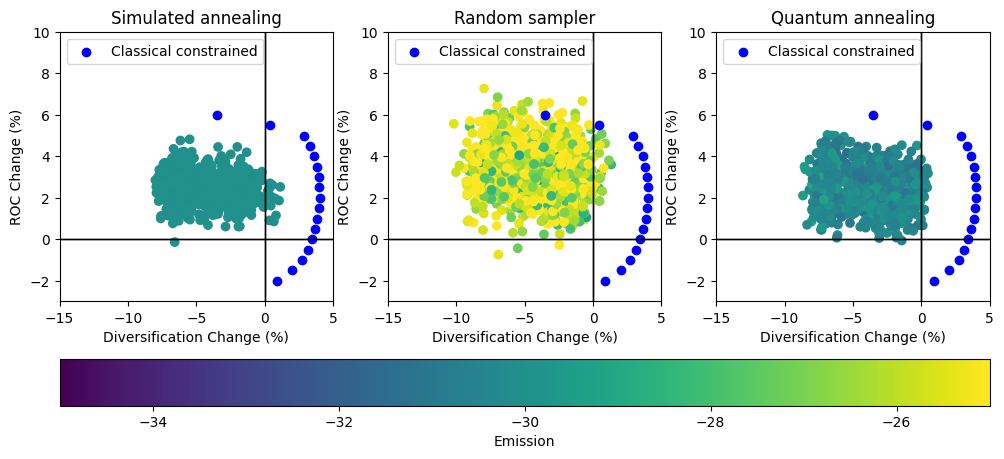

In [14]:
# Plot results
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
(ax1, ax2, ax3) = axs
scatter1 = plot_points(
    x1, y1, c=results_df1["diff emission"], cmap="viridis", ax=ax1, vmin=-35, vmax=-25
)
scatter2 = plot_points(
    x2, y2, c=results_df2["diff emission"], cmap="viridis", ax=ax2, vmin=-33, vmax=-25
)
if RUN_QUANTUM_ANNEALING_SAMPLER:
    scatter3 = plot_points(
        x3,
        y3,
        c=results_df3["diff emission"],
        cmap="viridis",
        ax=ax3,
        vmin=-33,
        vmax=-25,
    )

ax1.set_title("Simulated annealing")
ax2.set_title("Random sampler")
ax3.set_title("Quantum annealing")
cbar = fig.colorbar(scatter1, ax=axs, orientation="horizontal", label="Emission")

for ax in axs:
    plot_points(x_classical, y_classical, color="blue", label="Classical constrained", ax=ax)
    ax.set_xlim(-15, 5)
    ax.set_ylim(-3, 10)

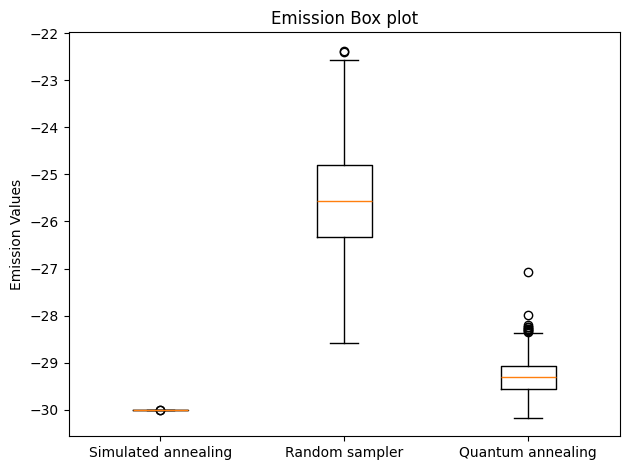

In [15]:
# Create boxplot of emission values
data = [results_df1["diff emission"], results_df2["diff emission"]]
labels = ["Simulated annealing", "Random sampler"]

if RUN_QUANTUM_ANNEALING_SAMPLER:
    data += [results_df3["diff emission"]]
    labels += ["Quantum annealing"]

plt.boxplot(data, labels=labels)

# Add labels and title
plt.ylabel("Emission Values")
plt.title("Emission Box plot")
plt.tight_layout()